# Part 3: Recognition

In this part of the assignment, you will implement and train neural networks, including convolutional neural networks, for an image recognition task using PyTorch. Specifically, we will classify a number of grayscale images of pieces of clothing by predicting a label for the name of the clothing type.

**Learning objectives.** You will:
1. Define multilayer perceptrons and convolutional neural networks using PyTorch
2. Optimize neural networks using automatic differentation and minibatch stochastic gradient descent in PyTorch
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

While it is possible to complete this task using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

In [1]:
# Run but DO NOT MODIFY this code

# Import modules
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Load Fashion MNIST datasets
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 15122976.27it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 306369.89it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1366429.25it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12539069.10it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



The following code then visualizes some random examples of the training data.

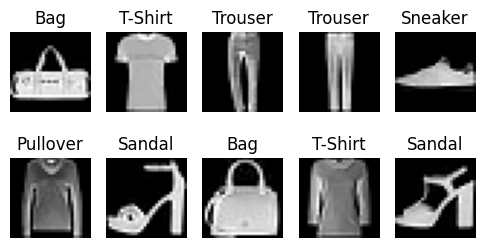

In [2]:
# Run but DO NOT MODIFY this code

# Visualize Random Examples
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

from matplotlib import pyplot as plt

figure = plt.figure(figsize=(6, 3))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
train_data[0][0].shape

torch.Size([1, 28, 28])

## Task 1

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a multilayer perceptron to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least at least two [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to connect between the input, hidden units, and an output units. You should use nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) at least for the hidden units. You may optionally include additional layers but are not required to do so.

Your model should not be excessively large beyond what is necessary to accomplish good performance (see the next task). After your code, briefly explain the architecture of your model including a discussion of the hidden layers and the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [4]:
# Write code for task 1 here

class MLP(torch.nn.Module):
    """Definition of a multilayer perceptron for classification
    in Pytorch, inheriting from the torch.nn.Module base class."""
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = torch.nn.Flatten()
        # todo: finish constructor/initialization
        self.hidden=torch.nn.Linear(
            in_features=28*28,
            out_features=120
        )
        self.out=torch.nn.Linear(
            in_features=120,
            out_features=10
        )


    def forward(self, x):
        x_flat=self.flatten(x)
        a_h=self.hidden(x_flat)
        z_h=torch.nn.functional.relu(a_h)
        out=self.out(z_h)
        return out

I essentially wanted to maximize the number of hidden units I would be able to use while staying under the 100,000 parameter limit. I found 120 hidden units to be the largest (with 28*28 in units and 10 out units), which resulted in 95410 parameters total.

## Task 2

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)).

You should be able to achieve a validation accuracy of 83% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 1 if so) or the training hyperparameters to accomplish this.

When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data. Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [5]:
gpu=torch.device("cuda")
model=MLP().to(gpu)
optimizer=torch.optim.SGD(model.parameters(),lr=0.025)
loss_fn=torch.nn.CrossEntropyLoss()
epochs=5
for epoch in range(epochs):
  for batch,(x,y) in enumerate(train_loader):
    x=x.to(gpu)
    y=y.to(gpu)
    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    val_loss=0;
    correct=0;
    for(x,y) in val_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      val_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/len(val_loader.dataset)
    print(f"Epoch num:{epoch}")
    print(f"Validation loss:{val_loss}")
    print(f"Validation accuracy:{accuracy}\n")

with torch.no_grad():
    test_loss=0;
    correct=0;
    for(x,y) in test_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      test_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/len(test_loader.dataset)
    print(f"Test loss:{val_loss}")
    print(f"Test accuracy:{accuracy}\n")

Epoch num:0
Validation loss:116.93469110131264
Validation accuracy:0.7865833333333333

Epoch num:1
Validation loss:99.12917649745941
Validation accuracy:0.82025

Epoch num:2
Validation loss:92.39391714334488
Validation accuracy:0.8325

Epoch num:3
Validation loss:88.89927662909031
Validation accuracy:0.8403333333333334

Epoch num:4
Validation loss:87.17748899757862
Validation accuracy:0.8426666666666667

Test loss:87.17748899757862
Test accuracy:0.8304



On the test data, I achieved an accuracy of 83.04%. I chose a lr of .025 and 5 epochs. I saw that anything higher than .025 would be too volatile and anything under wouldn't learn fast enough.

## Task 3

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a convolutional neural network to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least one [convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), at least one [pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), and at least one fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), though you may choose to use a deeper model with additional layers to achieve good performance.

Your model should not be excessively large beyond what is necessary to accomplish good performance. After your code, briefly explain the architecture of your model including a discussion of all of the hidden layers including choice of any parameters such as kernels or strides, as well as the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [7]:
# Write code for task 3 here

class ConvNN(torch.nn.Module):
    """Definition of a convolutional neural network for classification
    in Pytorch, inheriting from the torch.nn.Module base class."""
    def __init__(self):
        super().__init__()
        self.conv=torch.nn.Conv2d(
            in_channels=1,
            out_channels=5,
            kernel_size=(3,3),
            padding='same'
        )
        self.pool=torch.nn.MaxPool2d(
            kernel_size=(2,2),
            stride=2
        )
        self.flatten=torch.nn.Flatten()
        self.h=torch.nn.Linear(
            in_features=14*14*5,
            out_features=12
        )
        self.out=torch.nn.Linear(
            in_features=12,
            out_features=10
        )



    def forward(self, x):
        x_conv=self.conv(x)
        z_conv=torch.nn.functional.relu(x_conv)
        x_pool=self.pool(z_conv)
        x_flat=self.flatten(x_pool)
        x_h=self.h(x_flat)
        z_h=torch.nn.functional.relu(x_h)
        out=self.out(z_h)
        return out


I found that I only needed 11952 parameters to achieve a validation accuracy of 88%. I used 1 3x3 convolutional layer with padding to keep the same size and 1 2x2 max pooling layer with stride 2. From that point, I implemented 1 hidden linear layer with 980 inputs and 12 out units and 1 out later with 12 inputs and 10 outputs.

## Task 4

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

Instead of using printouts to monitor training, use the more professional PyTorch `Tensorboard` utility as [described in the tutorial documentation here](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html). Log the (a) training loss, (b) validation loss, and (c) validation accuracy over the course of training using `Tensorboard` (you likely only want to compute validation accuracy once per epoch, but you can log the loss more often if you wish). For your final training run, report the visualizations created by Tensorboard. You can export the visualizations from Tensorboard by selecting "SCALARs" (upper left), "Show data download links", and "Download" under each image, or you can just take screenshots. You can [add images using markdown as shown in the documentation](https://www.markdownguide.org/cheat-sheet/#basic-syntax).

You should be able to achieve a validation accuracy of 88% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 3 if so) or the training hyperparameters to accomplish this. In particular, you should demonstrate improved performance (while still using fewer than 100,000 parameters) compared to your previous multilayer perceptron. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [ ]:
!pip install tensorboard

import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
gpu=torch.device("cuda")
model=ConvNN().to(gpu)
print(count_parameters(model))
optimizer=torch.optim.SGD(model.parameters(),lr=0.05)
loss_fn=torch.nn.CrossEntropyLoss()
epochs=10
for epoch in range(epochs):
  for batch,(x,y) in enumerate(train_loader):
    x=x.to(gpu)
    y=y.to(gpu)
    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    val_loss=0
    correct=0
    train_loss=0
    for(x,y) in val_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      val_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    for(x,y) in train_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      train_loss+=loss_fn(y_pred,y).item()
    accuracy=correct/len(val_loader.dataset)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Loss/Accuracy", accuracy, epoch)
writer.flush()
print("done")
with torch.no_grad():
    test_loss=0;
    correct=0;
    for(x,y) in test_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      test_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/len(test_loader.dataset)
    print(f"Test loss:{val_loss}")
    print(f"Test accuracy:{accuracy}\n")
!tensorboard --logdir=runs

Defaulting to user installation because normal site-packages is not writeable


2024-10-20 19:57:45.162353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


11952
done
Test loss:62.18483451008797
Test accuracy:0.8767

2024-10-20 19:59:10.476011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.1 at http://localhost:6006/ (Press CTRL+C to quit)


![alt text](./Tensorboardpic.png)

I achieved an accuracy of about 88% using a convolutional layer while only using about 1/9 of the amount of trainable parameters compared to the MLP. I chose an lr of .05 because accuracy would increase the fastest without being too volatile. I used 10 epochs to achieve 88% accuracy.